In [33]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping


In [4]:
# 1) 데이터 로드
df = pd.read_csv("./data/training/final/travel_insight_pruned.csv")

In [ ]:
# 2) 타깃/식별자/피처 분리
TARGET = "IS_FAILED_TRIP"
ID_COLS = ["TRAVEL_ID"]
assert TARGET in df.columns, f"{TARGET} 컬럼이 없습니다."

X = df.drop(ID_COLS + [TARGET], axis=1)
y = df[TARGET].astype(int)

In [6]:
# 3) 수치/범주형 컬럼 자동 분류
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [7]:
# 4) 클래스 불균형 대응: scale_pos_weight = (neg/pos)
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"[Info] class ratio -> pos={pos}, neg={neg}, scale_pos_weight={scale_pos_weight:.2f}")

[Info] class ratio -> pos=251, neg=5508, scale_pos_weight=21.94


In [ ]:
# 5) 전처리 파이프라인 (원-핫 인코딩 + 나머지 수치 피처 그대로)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="passthrough"
)

In [ ]:
# 6) XGBoost 분류기
xgb_clf = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", xgb_clf),
])

In [ ]:
# 7) Stratified K-Fold + 조기종료
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = {"acc": [], "prec": [], "rec": [], "f1": [], "auc": []}

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    pipe["pre"].fit(X_tr)
    X_tr_enc = pipe["pre"].transform(X_tr)
    X_va_enc = pipe["pre"].transform(X_va)

    dtrain = xgb.DMatrix(X_tr_enc, label=y_tr)
    dvalid = xgb.DMatrix(X_va_enc, label=y_va)

    params = {
        "objective": "binary:logistic",
        "eta": 0.05,                 # learning_rate
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 1.0,               # reg_lambda
        "eval_metric": "logloss",    # 또는 "auc"
        "seed": 42 + fold,
        "scale_pos_weight": float(scale_pos_weight),
    }

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=100,
        verbose_eval=False
    )

    best_trees = getattr(booster, "best_ntree_limit", None)
    if best_trees is None:
        y_proba = booster.predict(dvalid)
    else:
        y_proba = booster.predict(dvalid, ntree_limit=best_trees)

    y_pred = (y_proba >= 0.5).astype(int)

    # 메트릭 계산
    acc  = accuracy_score(y_va, y_pred)
    prec = precision_score(y_va, y_pred, zero_division=0)
    rec  = recall_score(y_va, y_pred)
    f1   = f1_score(y_va, y_pred)
    auc  = roc_auc_score(y_va, y_proba)

    metrics["acc"].append(acc)
    metrics["prec"].append(prec)
    metrics["rec"].append(rec)
    metrics["f1"].append(f1)
    metrics["auc"].append(auc)

    print(f"[Fold {fold}] "
          f"Acc {acc:.4f} | Prec {prec:.4f} | Rec {rec:.4f} | F1 {f1:.4f} | AUC {auc:.4f}")

[Fold 1] Acc 0.8238 | Prec 0.0581 | Rec 0.1961 | F1 0.0897 | AUC 0.6576
[Fold 2] Acc 0.8238 | Prec 0.0726 | Rec 0.2600 | F1 0.1135 | AUC 0.6395
[Fold 3] Acc 0.8125 | Prec 0.0489 | Rec 0.1800 | F1 0.0769 | AUC 0.5832
[Fold 4] Acc 0.8359 | Prec 0.0629 | Rec 0.2000 | F1 0.0957 | AUC 0.6390
[Fold 5] Acc 0.8480 | Prec 0.0748 | Rec 0.2200 | F1 0.1117 | AUC 0.6148


In [23]:
# 8) 교차검증 평균/표준편차 요약
def ms(arr): 
    return f"{np.mean(arr):.4f} ± {np.std(arr):.4f}"

print("\n=== CV Summary (5-fold) ===")
print("Accuracy :", ms(metrics["acc"]))
print("Precision:", ms(metrics["prec"]))
print("Recall   :", ms(metrics["rec"]))
print("F1-score :", ms(metrics["f1"]))
print("ROC-AUC  :", ms(metrics["auc"]))


=== CV Summary (5-fold) ===
Accuracy : 0.8288 ± 0.0121
Precision: 0.0635 ± 0.0095
Recall   : 0.2112 ± 0.0275
F1-score : 0.0975 ± 0.0138
ROC-AUC  : 0.6268 ± 0.0257


In [ ]:
# 9) 최종 모델 재학습 (train/valid 스플릿 + 조기종료) 및 저장

X_tr_all, X_va_all, y_tr_all, y_va_all = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pre_final = preprocess.fit(X_tr_all)
X_tr_all_enc = pre_final.transform(X_tr_all)
X_va_all_enc = pre_final.transform(X_va_all)

ohe = pre_final.named_transformers_["cat"] if len(cat_cols) > 0 else None
if ohe is not None:
    try:
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    except AttributeError:
        ohe_names = ohe.get_feature_names(cat_cols).tolist()
else:
    ohe_names = []
feature_names = ohe_names + num_cols

dtrain = xgb.DMatrix(X_tr_all_enc, label=y_tr_all, feature_names=feature_names)
dvalid = xgb.DMatrix(X_va_all_enc,  label=y_va_all,  feature_names=feature_names)

params = {
    "objective": "binary:logistic",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "eval_metric": "logloss",
    "seed": 777,
    "scale_pos_weight": float(scale_pos_weight),
}

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=100,
    verbose_eval=False
)

best_trees = getattr(booster, "best_ntree_limit", None)
if best_trees is None:
    y_proba_f = booster.predict(dvalid)
else:
    y_proba_f = booster.predict(dvalid, ntree_limit=best_trees)
y_pred_f = (y_proba_f >= 0.5).astype(int)

print("\n[Final/holdout]")
print("Accuracy :", accuracy_score(y_va_all, y_pred_f))
print("Precision:", precision_score(y_va_all, y_pred_f, zero_division=0))
print("Recall   :", recall_score(y_va_all, y_pred_f))
print("F1-score :", f1_score(y_va_all, y_pred_f))
print("ROC-AUC  :", roc_auc_score(y_va_all, y_proba_f))
print("Confusion Matrix:\n", confusion_matrix(y_va_all, y_pred_f))

importance_gain = booster.get_score(importance_type="gain")

top_items = sorted(importance_gain.items(), key=lambda x: x[1], reverse=True)[:30]
print("\n[Top feature importances by gain]")
for name, score in top_items:
    print(f"{name:45s} {score:.6f}")

booster.save_model("xgb_final.json")
dump(pre_final, "preprocessor_ohe.joblib")

print("\n[Saved]")
print(" - xgb_final.json")
print(" - preprocessor_ohe.joblib")


[Final/holdout]
Accuracy : 0.8298611111111112
Precision: 0.054878048780487805
Recall   : 0.18
F1-score : 0.08411214953271028
ROC-AUC  : 0.6036660617059891
Confusion Matrix:
 [[947 155]
 [ 41   9]]

[Top feature importances by gain]
visit_move_cnt                                9.315050
TRAVEL_LENGTH                                 7.886256
total_payment_per_day                         7.190008
total_payment                                 6.904657
visit_move_cnt_per_day                        6.780916

[Saved]
 - xgb_final.json
 - preprocessor_ohe.joblib


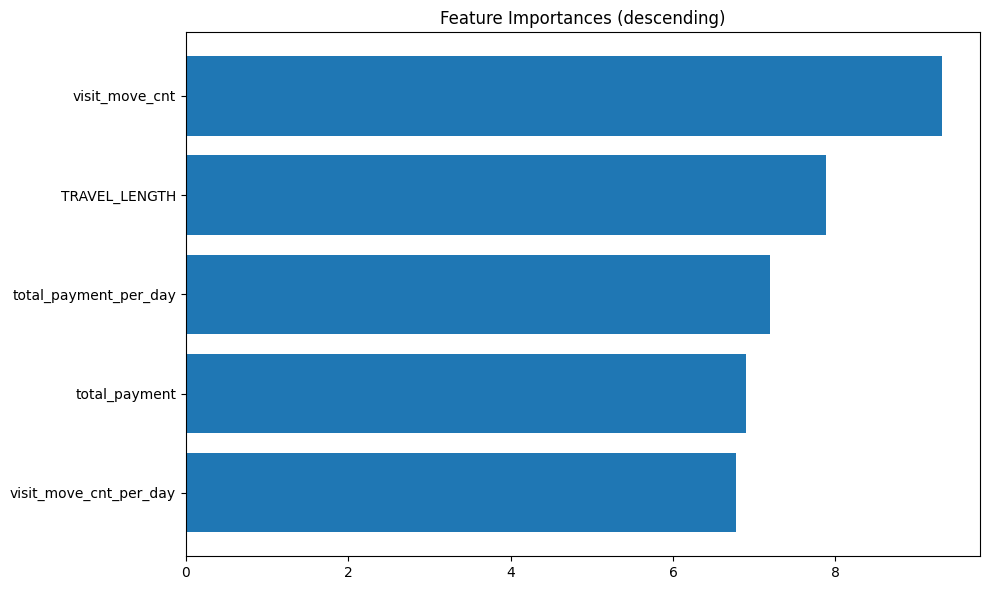

In [37]:
# 10) 중요도 상위 피처 확인 (원-핫 이름 포함)

order = np.argsort(importances)[::-1]
K = min(30, len(order))
idx = order[:K]

plt.figure(figsize=(10, 6))
plt.barh(range(K), importances[idx])
plt.yticks(range(K), [feature_names[i] for i in idx])
plt.gca().invert_yaxis()
plt.title("Feature Importances (descending)")
plt.tight_layout()
plt.show()
